We will load the model and do some inference to play with it.

In [1]:
from networks.RecursiveUNet import UNet
import torch
import os
import numpy as np
import nibabel as nib
from utils.utils import med_reshape
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline

In [2]:
model = UNet(num_classes=3)
model.load_state_dict(torch.load('../model.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [3]:
model.eval();

Model is loaded and ready to use. Let's start by pulling a random image from the training set.

In [4]:
data_path = '../../../section1/out/TrainingSet/'
filename = np.random.choice(os.listdir(os.path.join(data_path,'images')))
filename

'hippocampus_184.nii.gz'

In [5]:
image = nib.load(os.path.join(data_path,'images',filename))
image_array = image.get_fdata()
image_array.shape

(37, 51, 33)

In [6]:
image_array_padded = med_reshape(image_array, (image_array.shape[0],64,64))
image_array_padded.shape

(37, 64, 64)

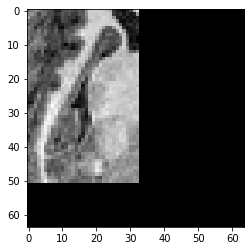

In [7]:
plt.imshow(image_array_padded[image_array_padded.shape[0]//2],cmap='gray')
plt.show()

In [8]:
x = torch.from_numpy(image_array_padded).type(torch.FloatTensor).unsqueeze(1)
with torch.no_grad():
    prediction = F.softmax(model(x), dim=1).numpy()
predicted_labels = prediction.argmax(axis=1)

In [9]:
predicted_labels.shape

(37, 64, 64)

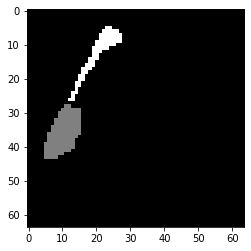

In [10]:
plt.imshow(predicted_labels[predicted_labels.shape[0]//2],cmap='gray')
plt.show()

In [11]:
predicted_labels_recropped = predicted_labels[:,:image_array.shape[1],:image_array.shape[2]]
predicted_labels_recropped.shape

(37, 51, 33)

Let's now save the predicted label so that it can later be played with in 3D slicer.

In [17]:
filename_base = filename.split('.')[0]
filename_base

'hippocampus_184'

In [18]:
output_path = '/home/ebrahime/Desktop'
output_nifti = nib.Nifti1Image(predicted_labels_recropped, image.affine, image.header)
nib.save(output_nifti, os.path.join(output_path,filename_base+'_prediction.nii.gz'))

Let's compute dice coefficient.

In [22]:
gt_label_array = nib.load(os.path.join(data_path,'labels',filename)).get_fdata()
assert(gt_label_array.shape==predicted_labels_recropped.shape)

In [27]:
gt_mask = gt_label_array!=0
pred_mask = predicted_labels_recropped!=0
dice = 2 * (gt_mask & pred_mask).sum() / (gt_mask.sum() + pred_mask.sum())
dice

0.9314993122420908

Now let's write a function that takes a filename, carries out inference, and returns the dice coefficient.

In [28]:
def dice_from_filename(filename):
    image_array = nib.load(os.path.join(data_path,'images',filename)).get_fdata()
    image_array_padded = med_reshape(image_array, (image_array.shape[0],64,64))
    x = torch.from_numpy(image_array_padded).type(torch.FloatTensor).unsqueeze(1)
    with torch.no_grad():
        prediction = F.softmax(model(x), dim=1).numpy()
    predicted_labels = prediction.argmax(axis=1)
    predicted_labels_recropped = predicted_labels[:,:image_array.shape[1],:image_array.shape[2]]
    gt_label_array = nib.load(os.path.join(data_path,'labels',filename)).get_fdata()
    assert(gt_label_array.shape==predicted_labels_recropped.shape)
    gt_mask = gt_label_array!=0
    pred_mask = predicted_labels_recropped!=0
    dice = 2 * (gt_mask & pred_mask).sum() / (gt_mask.sum() + pred_mask.sum())
    return dice

Let's do it to all files and see who is doing the worst in terms of dice coeff.

In [39]:
# This will take a while
filenames_and_dices = [(f, dice_from_filename(f)) for f in os.listdir(os.path.join(data_path,'images'))]

In [40]:
filenames_and_dices.sort(key = lambda p : p[1])
filenames_and_dices

[('hippocampus_330.nii.gz', 0.79858934169279),
 ('hippocampus_114.nii.gz', 0.8188952610926653),
 ('hippocampus_245.nii.gz', 0.8216115510013973),
 ('hippocampus_280.nii.gz', 0.8233510235026535),
 ('hippocampus_305.nii.gz', 0.8238419392329404),
 ('hippocampus_041.nii.gz', 0.8310589519650655),
 ('hippocampus_310.nii.gz', 0.8323651452282158),
 ('hippocampus_042.nii.gz', 0.8347826086956521),
 ('hippocampus_334.nii.gz', 0.8387462235649547),
 ('hippocampus_329.nii.gz', 0.8418896777717094),
 ('hippocampus_221.nii.gz', 0.8456112852664577),
 ('hippocampus_235.nii.gz', 0.8485139022051774),
 ('hippocampus_298.nii.gz', 0.8515652479774886),
 ('hippocampus_297.nii.gz', 0.8523391812865497),
 ('hippocampus_222.nii.gz', 0.8530517272239126),
 ('hippocampus_015.nii.gz', 0.8531845987765383),
 ('hippocampus_244.nii.gz', 0.8538628606887992),
 ('hippocampus_037.nii.gz', 0.8553299492385786),
 ('hippocampus_375.nii.gz', 0.8573553473151867),
 ('hippocampus_314.nii.gz', 0.8575104535220328),
 ('hippocampus_309.nii

In [51]:
#Take the three best and three worst and visualize them
worst = list(map(lambda p:p[0], filenames_and_dices[:3]))
best = list(map(lambda p:p[0], filenames_and_dices[-3:]))

def img_gt_pred(filename):
    "Return image array, ground truth label, and prediction given a filename"
    image_array = nib.load(os.path.join(data_path,'images',filename)).get_fdata()
    image_array_padded = med_reshape(image_array, (image_array.shape[0],64,64))
    x = torch.from_numpy(image_array_padded).type(torch.FloatTensor).unsqueeze(1)
    with torch.no_grad():
        prediction = F.softmax(model(x), dim=1).numpy()
    predicted_labels = prediction.argmax(axis=1)
    predicted_labels_recropped = predicted_labels[:,:image_array.shape[1],:image_array.shape[2]]
    gt_label_array = nib.load(os.path.join(data_path,'labels',filename)).get_fdata()
    return image_array, gt_label_array, predicted_labels_recropped

def display_middle_sagittal_comparison(filename):
    img, gt, pred = img_gt_pred(filename)
    fig, axs = plt.subplots(1,3)
    axs[0].set_title('image')
    axs[1].set_title('ground truth')
    axs[2].set_title('prediction')
    i = img.shape[0]//2
    axs[0].imshow(img[i],cmap='gray')
    axs[1].imshow(gt[i],cmap='gray')
    axs[2].imshow(pred[i],cmap='gray')

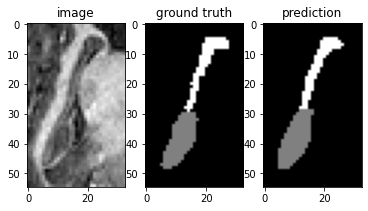

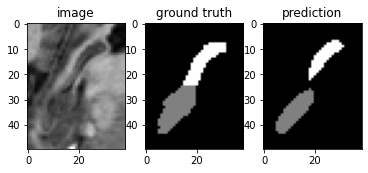

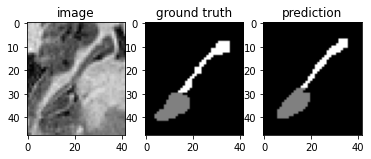

In [53]:
for f in worst:
    display_middle_sagittal_comparison(f)

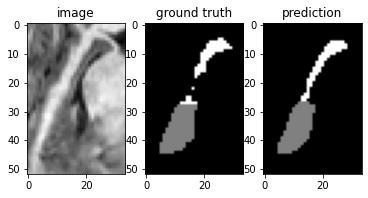

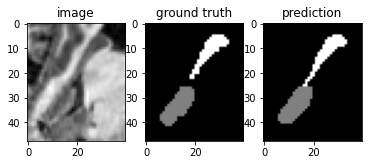

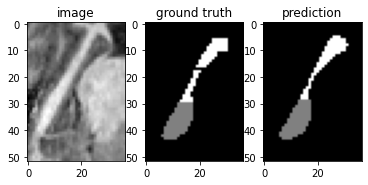

In [54]:
for f in best:
    display_middle_sagittal_comparison(f)

It looks like the regions surrounding the hippocampus are a lot brighter in the better-performing examples. Let's save one of the worst as NIFTI so we can explore it in 3D slicer:

In [55]:
def predict_and_save(filename , output_directory = '/home/ebrahime/Desktop'):
    "Run model on given filename to generate predicted label and save the label as NIFTI"
    image = nib.load(os.path.join(data_path,'images',filename))
    image_array = image.get_fdata()
    image_array_padded = med_reshape(image_array, (image_array.shape[0],64,64))
    x = torch.from_numpy(image_array_padded).type(torch.FloatTensor).unsqueeze(1)
    with torch.no_grad():
        prediction = F.softmax(model(x), dim=1).numpy()
    predicted_labels = prediction.argmax(axis=1)
    predicted_labels_recropped = predicted_labels[:,:image_array.shape[1],:image_array.shape[2]]
    filename_base = filename.split('.')[0]
    output_nifti = nib.Nifti1Image(predicted_labels_recropped, image.affine, image.header)
    nib.save(output_nifti, os.path.join(output_directory,filename_base+'_prediction.nii.gz'))

predict_and_save(worst[0])